### Testing Evo

#### Imports

In [1]:
import torch
from IPython.display import display, HTML, Image
from torch_geometric.loader import DataLoader

from settings import *
from generator import generate_organism
from GNCAConv import Conv
from visualizer import Visualizer
from evo_trainer import Evo_Trainer
from enums import EnvironmentType, ModelType
from food_env import *
from online_tracker import OnlineTracker

#### Train the network

In [2]:
wall_amount = 50
food_amount = 500
cluster_env = Cluster_Env(clusters=60, cluster_size=30, wall_amount=wall_amount)
centered_env = Centered_Env(food_amount=food_amount, wall_amount=wall_amount)
circle_env = Circle_Env(circles=4, food_amount=food_amount, wall_amount=wall_amount)
spiral_env = Spiral_Env(spirals=3, food_amount=food_amount, wall_amount=wall_amount)

In [3]:
train_config = Train_Config(stdev=0.03, popsize=10, 
    name='hidden10', problem_searcher=ProblemSearcher.CMAES,
    with_samplepool=False, timesteps=200)

In [4]:
generations = 200

settings = Settings(
    device = torch.device('cpu'),
    batch_size = 2,
    n = 10,
    #food_env=cluster_env,
    #food_env=centered_env,
    #food_env=circle_env,
    food_env=spiral_env,
    scale = 2,
    wrap_around = True,
    
    #model_type = ModelType.LocalOnly,
    #model_type = ModelType.WithGlobalNode,
    model_type = ModelType.SmallWorld,

    radius = 0.04,
    radius_food_scale = 5,
    consume_radius_scale = 3/4, 
    consumption_edge_required = 1,
    noise = 0.002,
    energy_required_to_replicate = 50,
    train_config=train_config,

    radius_wall_scale = 5,
    radius_wall_damage_scale = 1,
    wall_damage = 2,

    #only used if withGlobalNode
    #n2 = 
    radius_long_scale=2,
)

In [5]:
#TODO ADD settings like std of clusters..

online_tracker = OnlineTracker(settings)
trainer = Evo_Trainer(settings, online_tracker)
network = Conv(settings=settings)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: mmho (gnca). Use `wandb login --relogin` to force relogin


2023-04-12 21:51:58,307	INFO worker.py:1528 -- Started a local Ray instance.


[2023-04-12 21:52:00] INFO     <77928> evotorch.core: Instance of `Custom_NEProblem` (id:11207204752) -- The `dtype` for the problem's decision variables is set as torch.float32
[2023-04-12 21:52:00] INFO     <77928> evotorch.core: Instance of `Custom_NEProblem` (id:11207204752) -- `eval_dtype` (the dtype of the fitnesses and evaluation data) is set as torch.float32
[2023-04-12 21:52:00] INFO     <77928> evotorch.core: Instance of `Custom_NEProblem` (id:11207204752) -- The `device` of the problem is set as cpu
[2023-04-12 21:52:00] INFO     <77928> evotorch.core: Instance of `Custom_NEProblem` (id:11207204752) -- The number of actors that will be allocated for parallelized evaluation is 10
[2023-04-12 21:52:00] INFO     <77928> evotorch.core: Instance of `Custom_NEProblem` (id:11207204752) -- Number of GPUs that will be allocated per actor is None


/Users/martinholst/miniconda3/envs/AML/lib/python3.10/site-packages/evotorch/tools/misc.py:1107: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  result = torch.tensor(data, **kwargs)


In [6]:
#trainer.train(10, 'temp')
#trainer.load_searcher() #load existing session

In [7]:
generations=100

In [8]:
trainer.train(generations)

         iter : 1
     stepsize : ReadOnlyTensor(0.0300)
pop_best_eval : 8.0
  median_eval : 3.0
    mean_eval : 3.700000047683716

         iter : 2
     stepsize : ReadOnlyTensor(0.0299)
pop_best_eval : 34.5
  median_eval : 2.5
    mean_eval : 6.099999904632568

         iter : 3
     stepsize : ReadOnlyTensor(0.0299)
pop_best_eval : 16.0
  median_eval : 3.0
    mean_eval : 5.199999809265137

         iter : 4
     stepsize : ReadOnlyTensor(0.0299)
pop_best_eval : 16.5
  median_eval : 1.5
    mean_eval : 5.150000095367432

         iter : 5
     stepsize : ReadOnlyTensor(0.0299)
pop_best_eval : 2.5
  median_eval : 0.0
    mean_eval : 0.550000011920929

         iter : 6
     stepsize : ReadOnlyTensor(0.0298)
pop_best_eval : 12.0
  median_eval : 7.0
    mean_eval : 7.150000095367432

         iter : 7
     stepsize : ReadOnlyTensor(0.0298)
pop_best_eval : 9.0
  median_eval : 4.0
    mean_eval : 4.050000190734863

         iter : 8
     stepsize : ReadOnlyTensor(0.0298)
pop_best_eval :

In [9]:
network = trainer.get_trained_network()
online_tracker.add_model(network)

#### Visualize trained network

In [10]:
graphs = [generate_organism(settings).toGraph() for _ in range(settings.batch_size)]
loader = DataLoader(graphs, batch_size=settings.batch_size)
graph = next(iter(loader))
visualizer = Visualizer(settings)
network(graph, 0)

DataBatch(x=[1120, 11], edge_index=[1, 0], device=[2], subsize=[2], velocity=[2], border_cost=[2], food_reward=[2], dead_cost=[2], visible_food=[2], food_avg_dist=[2], food_avg_degree=[2], food_search_movement=[2], batch=[1120], ptr=[3])

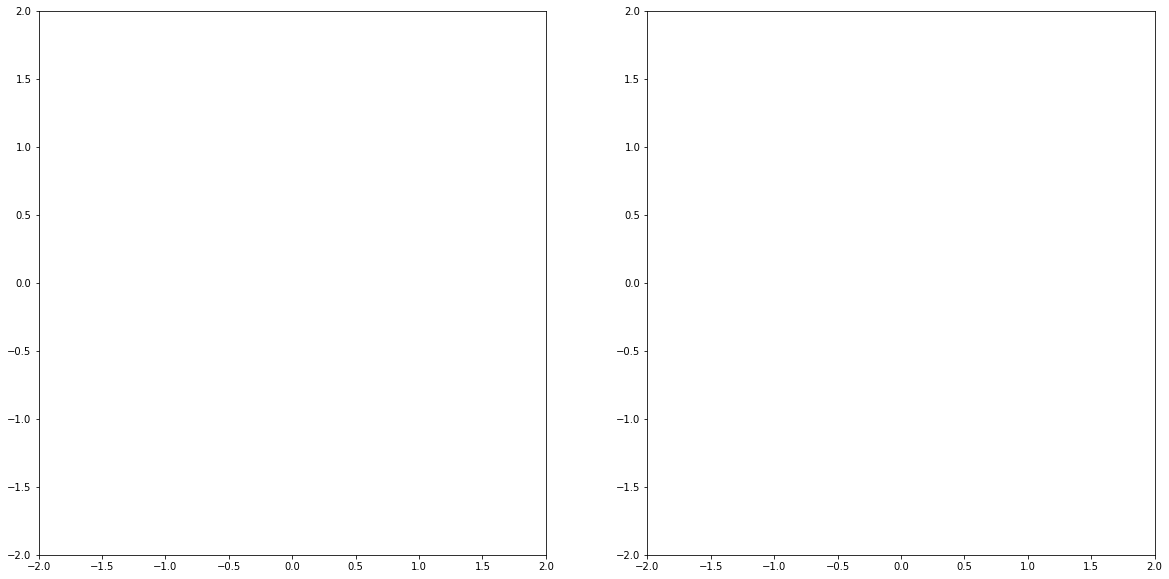

In [11]:
frames = 80 #test
#frames = 200 #visualize

#dpi = 200 #beautiful
dpi = 50 #fast

anim = visualizer.animate_organism(graph, network, food=30, frames=frames) 
visualizer.save_animation_to_gif(anim, train_config.name, fps=10, dpi=dpi)

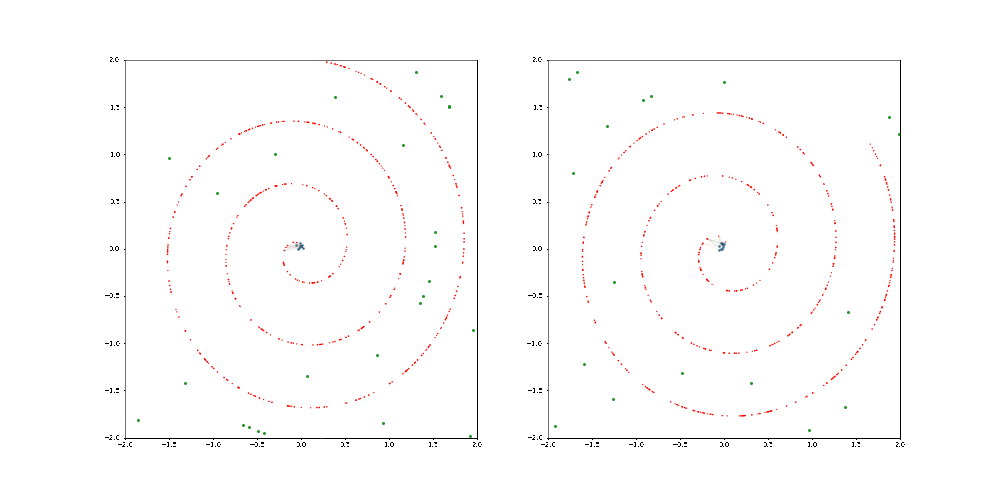

In [12]:
Image('../animation/' + train_config.name + '.gif')

In [13]:
%%javascript
IPython.notebook.save_notebook()

<IPython.core.display.Javascript object>

#### Visualization of loss:

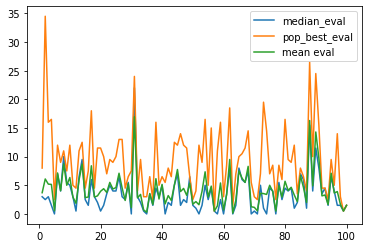

In [14]:
import matplotlib.pyplot as plt
losses = trainer.logger_df
#print(losses)
#plt.plot(losses.stepsize)

if settings.train_config.problem_searcher == ProblemSearcher.GeneticAlgorithm:
    plt.plot(losses.obj0_median_eval)
    plt.plot(losses.obj0_pop_best_eval)
    plt.plot(losses.obj0_mean_eval)
else:
    plt.plot(losses.median_eval)
    plt.plot(losses.pop_best_eval)
    plt.plot(losses.mean_eval)
plt.legend(('median_eval', 'pop_best_eval', 'mean eval'))
plt.show()

In [15]:
#online_tracker.finish()